# [05] COVID Test Evaluation

`01-04`까지의 실습을 기반으로 우리는 신경망을 학습하였습니다.

본 실습에서는 이것의 성능을 한번 얻어보겠습니다.

# 테스트 데이터셋 만들기

In [1]:
import os

In [ ]:
#!wget https://www.dropbox.com/s/2uexgt7rnyi5ep4/covid19-radiography-database.zip?dl=0

In [2]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
   creating: covid19-radiography-database/
   creating: covid19-radiography-database/Viral Pneumonia/
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (1299).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (1224).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (122).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (186).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (1075).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (1010).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (437).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (128).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (220).png  
  inflating: covid19-radiography-database/Viral Pneumonia/Viral Pneumonia (10

In [3]:
# 01을 참고하여 test directory를 만들어보세요
????????
????????

In [5]:
import shutil

In [6]:
COVID_TEST = './covid19-radiography-database/COVID-19'
NORMAL_TEST = './covid19-radiography-database/NORMAL'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('./COVID19-DATASET/test/covid19', image))
for image in os.listdir(NORMAL_TEST)[:100]:
    shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('./COVID19-DATASET/test/normal', image))

----

## Test/evaluation을 위한 작업

1. test dataloader 만들기
2. train으로 저장했던 모델 불러오기
3. accuracy / confusion matrix / precesion & recall 등의 통계적 값 불러오기
4. 사진을 띄우면서 실제로 예측해보기

In [24]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from materials.mobilenetv2 import mobilenet_v2
import tqdm

Q) Test Data에서는 Normalize를 해야하는 것이 맞을지요?

Q) 어떻게 Transform함수를 구성해야할까요?

In [17]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      ?????????
])


test_image = datasets.ImageFolder(???????)

testloader = torch.utils.data.DataLoader(???????????)
class_names = testloader.dataset.classes

In [19]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [20]:
model = mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

`04`에서 학습하였던 신경망을 불러옵니다.

In [22]:
model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


아래는 test loader를 돌며, prediction을 저장해두기 위함입니다.

In [26]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader):
        x_batch, y_batch = ??????, ???????
        y_test_pred = ??????????
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

100%|██████████| 200/200 [00:05<00:00, 39.40it/s]


In [27]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       100
           1       1.00      0.81      0.90       100

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.90       200
weighted avg       0.92      0.91      0.90       200



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

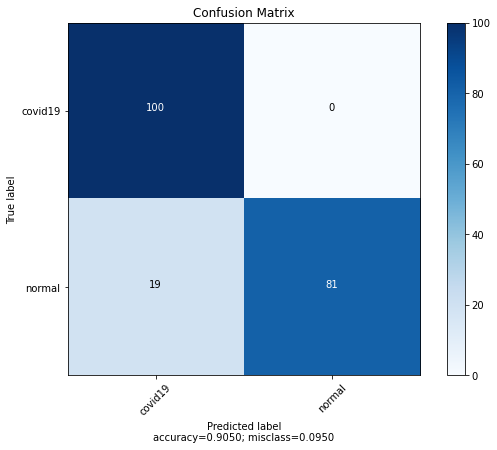

In [32]:
cm =  confusion_matrix(?????????????)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [36]:
import cv2
from torch.autograd import Variable
from PIL import Image

In [42]:
model = model.to('cpu')

In [43]:
#Inference function

def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

Predicted: covid19


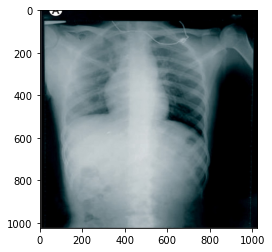

In [44]:
predict('./COVID19-DATASET/test/covid19/COVID-19 (100).png') #Sample Image Path

---------
### <심화>

- 본 test dataset에서의 분석으로 확률의 분포 (i.e., calibration 정보)를 뽑아보세요.
- 생각나는 다른 분석할 수 있는 것들을 생각해보세요.

------------